In [4]:
from trackml.dataset import load_event
from trackml.utils import add_position_quantities, add_momentum_quantities, decode_particle_id

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm

import sys
import os

#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Añadir la carpeta principal del repo al path
sys.path.append(os.path.abspath(".."))

LAPTOP = True
if LAPTOP == True:
    path = r'/mnt/d/TFG - Dataset/DATASET/train_1/'
    event = 'event000001000'
    hits, cells, particles, truth = load_event(path + event)

if LAPTOP == False:
    path = '/nfs/fanae/user/uo290313/Desktop/TFG/dataset/trackml-particle-identification/train_1/'
    event = 'event000001000'

print('Loading event {}'.format(path + event))

hits, cells, particles, truth = load_event(path + event)

mem_bytes = (hits.memory_usage(index=True).sum() 
             + cells.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())
print('{} memory usage {:.2f} MB'.format(event, mem_bytes / 2**20))

Loading event /mnt/d/TFG - Dataset/DATASET/train_1/event000001000
event000001000 memory usage 18.46 MB


# Búsqueda de pares prometedores

In [5]:
# #============== CONSIDERO SOLO LOS HITS DE LA PARTE CENTRAL DEL DETECTOR ==============#
# from commonMLfunctions import hits_vertex
# hits, cells, particles, truth = load_event(path+event)
# hits, particles = hits_vertex(hits, particles, truth)

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.utils import resample
from kalman_filter import get_hits_dict
from commonMLfunctions import hits_vertex

PARTICLES_FROM_VERTEX = True  # Si se quiere usar los hits de la parte central del detector
N_events = 31
events = []
for i in range(0, N_events):
    event = f'event0000010{i:02d}'
    events.append(event)
    # Tomamos el evento de última itración como evento de validación
    event_validation = f'event0000010{i:02d}' if i == N_events else None
#events = ['event000001000', 'event000001001', 'event000001002']
print(f"Procesando {len(events)} eventos: {events}")

for event in events:
    print(f"\n========================= Procesando evento: {event} =========================\n")
    hits, cells, particles, truth = load_event(path + event)

    hits, particles = hits_vertex(hits, particles, truth, PARTICLES_FROM_VERTEX= PARTICLES_FROM_VERTEX)
    
    data_dir = '/mnt/d/TFG - Dataset/OUTPUT'
    output_path = os.path.join(data_dir, f'triplets_data_{event}.npz')

    from commonMLfunctions import filtering_by_theta
    # Filtrado de hits por theta
    thetamin, thetamax = filtering_by_theta(hits)

    # Selección de volúmenes
    volume_ids = hits['volume_id'].unique()
    volume_ids = volume_ids[[1, 4, 7]]  
    first_volume = volume_ids[0]

    hits_dict = get_hits_dict(hits, volume_ids, OCTANTE=False, angle_range=(-round(thetamin), round(thetamax)), p_range = (0.5, np.inf))

    # Capas
    first_layer = sorted(hits_dict[first_volume].keys())[0]
    second_layer = sorted(hits_dict[first_volume].keys())[1]
    third_layer = sorted(hits_dict[first_volume].keys())[2]

    layer1 = hits_dict[first_volume][first_layer]
    layer2 = hits_dict[first_volume][second_layer]
    layer3 = hits_dict[first_volume][third_layer]

    coords1 = layer1[['x', 'y', 'z']].values
    coords2 = layer2[['x', 'y', 'z']].values
    coords3 = layer3[['x', 'y', 'z']].values

    ids1 = layer1['particle_id'].values
    ids2 = layer2['particle_id'].values
    ids3 = layer3['particle_id'].values

    cone_angle = np.deg2rad(0.5)

    def angle(v1, v2):
        cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        return np.arccos(np.clip(cos_theta, -1.0, 1.0))

    triplets = []
    labels = []

    if os.path.exists(output_path):
        print(f"El archivo {output_path} ya existe. Cargando datos preprocesados...")
        data = np.load(output_path, allow_pickle=True)
        X = data['X']
        y = data['y']
        scaler = data['scaler'].item()  # allow_pickle=True permite .item()
        print(f"Shape de X: {X.shape}, Shape de y: {y.shape}")


    else:
        print(f"El archivo {output_path} no existe. Generando triplets...")
        from tqdm import tqdm
        for i, v1 in enumerate(tqdm(coords1, desc=f"Generando tripletes para {event} ...")):
            id1 = ids1[i]
            for j, v2 in enumerate(coords2):
                id2 = ids2[j]
                if angle(v1, v2) < cone_angle:
                    for k, v3 in enumerate(coords3):
                        id3 = ids3[k]
                        if angle(v2, v3) < cone_angle:
                            triplet = np.stack([v1, v2, v3])
                            label = int(id1 == id2 == id3)
                            triplets.append(triplet)
                            labels.append(label)

        triplets = np.array(triplets)
        labels = np.array(labels)

        positive_idx = np.where(labels == 1)[0]
        negative_idx = np.where(labels == 0)[0]

        n_pos = len(positive_idx)
        n_neg = len(negative_idx)

        BALANCEO = False
        if BALANCEO:
            if n_pos > 0 and n_neg >= n_pos:
                negative_sample = resample(negative_idx, replace=False, n_samples=n_pos, random_state=42)
                selected_idx = np.concatenate([positive_idx, negative_sample])
            elif n_neg < n_pos:
                selected_idx = np.concatenate([positive_idx[:n_neg], negative_idx])
            else:
                selected_idx = np.array([])
            X = triplets[selected_idx]
            y = labels[selected_idx]
            print(f"Después del balanceo:\n Positivos: {np.sum(y == 1)}, Negativos: {np.sum(y == 0)}")
        else:
            X = triplets
            y = labels
            print(f"Sin balanceo: Positivos = {np.sum(y == 1)}, Negativos = {np.sum(y == 0)}")

    # Escalado
    from sklearn.preprocessing import StandardScaler
    X_scaled = X.reshape(X.shape[0], -1)
    X_original = X.reshape(X.shape[0], -1)  # Guardar antes de escalar
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_original)

    np.savez(output_path, 
            X=X_scaled,
            y=y, 
            scaler=scaler, 
            triplets_original=X_original)
    file_size_mb = os.path.getsize(output_path) / (1024 * 1024)  # Tamaño en MB
    print(f"Datos guardados en {output_path}.\n\tTamaño del archivo generado: {file_size_mb:.2f} MB")

Procesando 30 eventos: ['event000001000', 'event000001001', 'event000001002', 'event000001003', 'event000001004', 'event000001005', 'event000001006', 'event000001007', 'event000001008', 'event000001009', 'event000001010', 'event000001011', 'event000001012', 'event000001013', 'event000001014', 'event000001015', 'event000001016', 'event000001017', 'event000001018', 'event000001019', 'event000001020', 'event000001021', 'event000001022', 'event000001023', 'event000001024', 'event000001025', 'event000001026', 'event000001027', 'event000001028', 'event000001029']

========================= Procesando evento: event000001000 =========================

Los datos que tomo son un 29.4380% de los datos originales
Mínimo p: 0.15 GeV/c
Máximo p: 461.76 GeV/c
Número de partículas totales: 12263
Número de partículas únicas con p<0.5 GeV/C: 411
   hit_id          x         y       z  volume_id  layer_id  module_id  \
0       2 -55.336102  0.635342 -1502.5          7         2          1   
1      10 -9

Generando tripletes para event000001010 ...: 100%|██████████| 2092/2092 [00:46<00:00, 44.56it/s]


Sin balanceo: Positivos = 418, Negativos = 140
Datos guardados en /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001010.npz.
	Tamaño del archivo generado: 0.04 MB

========================= Procesando evento: event000001011 =========================

Los datos que tomo son un 21.9490% de los datos originales
Mínimo p: 0.15 GeV/c
Máximo p: 83.86 GeV/c
Número de partículas totales: 11630
Número de partículas únicas con p<0.5 GeV/C: 340
   hit_id           x         y       z  volume_id  layer_id  module_id  \
0       1  -60.458900  -4.53252 -1502.5          7         2          1   
1       2  -82.185204  -6.64366 -1502.5          7         2          1   
2       3  -62.490799 -10.25960 -1502.5          7         2          1   
3      11  -65.478500   1.89345 -1502.5          7         2          1   
4      14 -151.393997 -14.38230 -1502.0          7         2          2   

          particle_id         phi       theta          p  
0  333270220716113920  184.287369  177.689255  51

Generando tripletes para event000001011 ...: 100%|██████████| 1898/1898 [00:38<00:00, 49.93it/s]


Sin balanceo: Positivos = 417, Negativos = 123
Datos guardados en /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001011.npz.
	Tamaño del archivo generado: 0.04 MB

========================= Procesando evento: event000001012 =========================

Los datos que tomo son un 33.9346% de los datos originales
Mínimo p: 0.15 GeV/c
Máximo p: 83.01 GeV/c
Número de partículas totales: 10874
Número de partículas únicas con p<0.5 GeV/C: 458
   hit_id           x         y       z  volume_id  layer_id  module_id  \
0       5  -67.920502  -7.22626 -1502.5          7         2          1   
1       8  -56.116001   1.22596 -1502.5          7         2          1   
2      10  -91.166298 -15.12440 -1502.5          7         2          1   
3      13  -63.277000   1.16393 -1502.5          7         2          1   
4      19 -143.425003  -4.11863 -1502.0          7         2          2   

          particle_id         phi       theta          p  
0  495402487361044480  186.073029  177.397110  20

Generando tripletes para event000001012 ...: 100%|██████████| 2934/2934 [01:35<00:00, 30.72it/s]


Sin balanceo: Positivos = 718, Negativos = 305
Datos guardados en /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001012.npz.
	Tamaño del archivo generado: 0.08 MB

========================= Procesando evento: event000001013 =========================

Los datos que tomo son un 22.8533% de los datos originales
Mínimo p: 0.16 GeV/c
Máximo p: 186.52 GeV/c
Número de partículas totales: 10343
Número de partículas únicas con p<0.5 GeV/C: 303
   hit_id           x          y       z  volume_id  layer_id  module_id  \
0       1  -98.846199  -9.910940 -1502.5          7         2          1   
1       5  -84.643799   0.936811 -1502.5          7         2          1   
2      10  -74.731003  -6.006840 -1502.5          7         2          1   
3      11  -59.903900 -11.410200 -1502.5          7         2          1   
4      16 -131.477997  -7.054650 -1502.0          7         2          2   

          particle_id         phi       theta          p  
0  180146596434935808  185.725708  176.217

Generando tripletes para event000001013 ...: 100%|██████████| 1866/1866 [00:34<00:00, 53.41it/s]


Sin balanceo: Positivos = 390, Negativos = 110
Datos guardados en /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001013.npz.
	Tamaño del archivo generado: 0.04 MB

========================= Procesando evento: event000001014 =========================

Los datos que tomo son un 25.3943% de los datos originales
Mínimo p: 0.16 GeV/c
Máximo p: 135.03 GeV/c
Número de partículas totales: 12663
Número de partículas únicas con p<0.5 GeV/C: 414
   hit_id          x         y       z  volume_id  layer_id  module_id  \
0       3 -58.275101  -1.45169 -1502.5          7         2          1   
1       9 -68.488998 -12.08580 -1502.5          7         2          1   
2      11 -78.256798 -12.60380 -1502.5          7         2          1   
3      14 -64.389503   1.67823 -1502.5          7         2          1   
4      15 -89.910202 -15.47700 -1502.5          7         2          1   

          particle_id         phi       theta          p  
0  391818871297802240  181.427002  177.778183  10.4536

Generando tripletes para event000001014 ...: 100%|██████████| 2392/2392 [00:58<00:00, 40.88it/s]


Sin balanceo: Positivos = 448, Negativos = 165
Datos guardados en /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001014.npz.
	Tamaño del archivo generado: 0.05 MB

========================= Procesando evento: event000001015 =========================

Los datos que tomo son un 29.7126% de los datos originales
Mínimo p: 0.13 GeV/c
Máximo p: 139.28 GeV/c
Número de partículas totales: 12322
Número de partículas únicas con p<0.5 GeV/C: 422
   hit_id          x        y       z  volume_id  layer_id  module_id  \
0       1 -94.462997  -3.3468 -1502.5          7         2          1   
1       2 -98.716698 -10.9540 -1502.5          7         2          1   
2       3 -73.195900 -12.6067 -1502.5          7         2          1   
3       4 -81.944298 -11.1386 -1502.5          7         2          1   
4       8 -91.118500 -12.8637 -1502.5          7         2          1   

          particle_id         phi       theta          p  
0  351284138189258752  182.029129  176.400253   9.465536  
1

Generando tripletes para event000001015 ...: 100%|██████████| 2822/2822 [01:26<00:00, 32.69it/s]


Sin balanceo: Positivos = 588, Negativos = 228
Datos guardados en /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001015.npz.
	Tamaño del archivo generado: 0.06 MB

========================= Procesando evento: event000001016 =========================

Los datos que tomo son un 23.6289% de los datos originales
Mínimo p: 0.12 GeV/c
Máximo p: 70.42 GeV/c
Número de partículas totales: 11770
Número de partículas únicas con p<0.5 GeV/C: 402
   hit_id          x          y       z  volume_id  layer_id  module_id  \
0       5 -73.931396  -4.338970 -1502.5          7         2          1   
1      15 -84.070602  -8.497300 -1502.5          7         2          1   
2      17 -60.536400  -7.848830 -1502.5          7         2          1   
3      18 -87.649300 -13.643900 -1502.5          7         2          1   
4      20 -54.904800  -0.735044 -1502.5          7         2          1   

           particle_id         phi       theta          p  
0   855687640052137984  183.358795  177.178146  

Generando tripletes para event000001016 ...: 100%|██████████| 2082/2082 [00:46<00:00, 44.52it/s]


Sin balanceo: Positivos = 479, Negativos = 264
Datos guardados en /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001016.npz.
	Tamaño del archivo generado: 0.06 MB

========================= Procesando evento: event000001017 =========================

Los datos que tomo son un 25.0581% de los datos originales
Mínimo p: 0.16 GeV/c
Máximo p: 110.53 GeV/c
Número de partículas totales: 12407
Número de partículas únicas con p<0.5 GeV/C: 356
   hit_id          x         y       z  volume_id  layer_id  module_id  \
0       2 -56.666000  -6.84205 -1502.5          7         2          1   
1       5 -76.435204  -7.29452 -1502.5          7         2          1   
2       7 -69.102997  -2.95587 -1502.5          7         2          1   
3       9 -82.872101 -14.52180 -1502.5          7         2          1   
4      13 -85.785599  -1.76109 -1502.5          7         2          1   

          particle_id         phi       theta          p  
0  783626403881943040  186.884766  177.824463   6.3811

Generando tripletes para event000001017 ...: 100%|██████████| 2347/2347 [00:58<00:00, 40.04it/s]


Sin balanceo: Positivos = 522, Negativos = 154
Datos guardados en /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001017.npz.
	Tamaño del archivo generado: 0.05 MB

========================= Procesando evento: event000001018 =========================

Los datos que tomo son un 25.5845% de los datos originales
Mínimo p: 0.15 GeV/c
Máximo p: 91.68 GeV/c
Número de partículas totales: 8796
Número de partículas únicas con p<0.5 GeV/C: 297
   hit_id           x         y       z  volume_id  layer_id  module_id  \
0       4  -58.762299 -10.31720 -1502.5          7         2          1   
1       9  -95.114700  -5.10334 -1502.5          7         2          1   
2      14  -61.480000  -4.46242 -1502.5          7         2          1   
3      20 -135.408005   1.57308 -1502.0          7         2          2   
4      34  -58.607601 -10.29100 -1498.0          7         2          4   

          particle_id         phi       theta          p  
0  468383432217460736  189.958221  177.726089  19.

Generando tripletes para event000001018 ...: 100%|██████████| 1861/1861 [00:36<00:00, 50.87it/s]


Sin balanceo: Positivos = 424, Negativos = 121
Datos guardados en /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001018.npz.
	Tamaño del archivo generado: 0.04 MB

========================= Procesando evento: event000001019 =========================

Los datos que tomo son un 24.7825% de los datos originales
Mínimo p: 0.16 GeV/c
Máximo p: 115.73 GeV/c
Número de partículas totales: 12355
Número de partículas únicas con p<0.5 GeV/C: 371
   hit_id           x          y       z  volume_id  layer_id  module_id  \
0       3  -63.292198  -0.793297 -1502.5          7         2          1   
1      11  -83.383003  -9.345970 -1502.5          7         2          1   
2      12  -58.811401 -12.027100 -1502.5          7         2          1   
3      14  -92.384499 -11.960300 -1502.5          7         2          1   
4      20 -131.001007 -12.138000 -1502.0          7         2          2   

          particle_id         phi       theta          p  
0  797141738249519104  180.718124  177.587

Generando tripletes para event000001019 ...: 100%|██████████| 2350/2350 [01:01<00:00, 38.30it/s]


Sin balanceo: Positivos = 607, Negativos = 187
Datos guardados en /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001019.npz.
	Tamaño del archivo generado: 0.06 MB

========================= Procesando evento: event000001020 =========================

Los datos que tomo son un 22.3722% de los datos originales
Mínimo p: 0.16 GeV/c
Máximo p: 59.14 GeV/c
Número de partículas totales: 9041
Número de partículas únicas con p<0.5 GeV/C: 275
   hit_id          x         y       z  volume_id  layer_id  module_id  \
0       3 -64.603699  -9.22218 -1502.5          7         2          1   
1       7 -59.985298   1.82423 -1502.5          7         2          1   
2       8 -67.969002 -12.34580 -1502.5          7         2          1   
3      11 -75.017601  -7.38357 -1502.5          7         2          1   
4      13 -61.166500  -3.73559 -1502.5          7         2          1   

          particle_id         phi       theta          p  
0  342275633264459776  188.124084  177.513000   3.572758

Generando tripletes para event000001020 ...: 100%|██████████| 1588/1588 [00:25<00:00, 61.56it/s]


Sin balanceo: Positivos = 375, Negativos = 89
Datos guardados en /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001020.npz.
	Tamaño del archivo generado: 0.04 MB

========================= Procesando evento: event000001021 =========================

Los datos que tomo son un 23.0794% de los datos originales
Mínimo p: 0.15 GeV/c
Máximo p: 100.06 GeV/c
Número de partículas totales: 10287
Número de partículas únicas con p<0.5 GeV/C: 308
   hit_id           x          y       z  volume_id  layer_id  module_id  \
0       1  -70.454803 -11.588500 -1502.5          7         2          1   
1       3  -67.588898  -2.836710 -1502.5          7         2          1   
2      15  -88.154198  -0.342559 -1502.5          7         2          1   
3      18  -67.692802  -5.101840 -1502.5          7         2          1   
4      23 -153.166000  -4.753800 -1502.0          7         2          2   

          particle_id         phi       theta          p  
0   76562361896402944  189.340469  177.2792

Generando tripletes para event000001021 ...: 100%|██████████| 1825/1825 [00:34<00:00, 53.07it/s]


Sin balanceo: Positivos = 415, Negativos = 179
Datos guardados en /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001021.npz.
	Tamaño del archivo generado: 0.05 MB

========================= Procesando evento: event000001022 =========================

Los datos que tomo son un 30.7863% de los datos originales
Mínimo p: 0.15 GeV/c
Máximo p: 586.62 GeV/c
Número de partículas totales: 10141
Número de partículas únicas con p<0.5 GeV/C: 395
   hit_id           x          y       z  volume_id  layer_id  module_id  \
0       2  -72.134804 -10.316400 -1502.5          7         2          1   
1       8  -84.644501 -14.109600 -1502.5          7         2          1   
2      14  -58.891300   1.358630 -1502.5          7         2          1   
3      25 -165.662003 -15.242100 -1502.0          7         2          2   
4      30 -139.091003 -20.790701 -1498.0          7         2          3   

          particle_id         phi       theta          p  
0  711569909355642880  188.139008  177.223

Generando tripletes para event000001022 ...: 100%|██████████| 2438/2438 [01:03<00:00, 38.65it/s]


Sin balanceo: Positivos = 546, Negativos = 225
Datos guardados en /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001022.npz.
	Tamaño del archivo generado: 0.06 MB

========================= Procesando evento: event000001023 =========================

Los datos que tomo son un 26.5501% de los datos originales
Mínimo p: 0.16 GeV/c
Máximo p: 77.26 GeV/c
Número de partículas totales: 12975
Número de partículas únicas con p<0.5 GeV/C: 450
   hit_id          x         y       z  volume_id  layer_id  module_id  \
0       1 -56.260101 -8.415050 -1502.5          7         2          1   
1       2 -72.124901 -1.839520 -1502.5          7         2          1   
2       4 -58.097900 -0.835885 -1502.5          7         2          1   
3      10 -74.729401  0.362915 -1502.5          7         2          1   
4      13 -56.258202 -4.853930 -1502.5          7         2          1   

          particle_id         phi       theta          p  
0   45037714260623360  188.506912  177.831757  12.02612

Generando tripletes para event000001023 ...: 100%|██████████| 2503/2503 [01:07<00:00, 37.25it/s]


Sin balanceo: Positivos = 599, Negativos = 311
Datos guardados en /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001023.npz.
	Tamaño del archivo generado: 0.07 MB

========================= Procesando evento: event000001024 =========================

Los datos que tomo son un 25.0622% de los datos originales
Mínimo p: 0.15 GeV/c
Máximo p: 88.83 GeV/c
Número de partículas totales: 11602
Número de partículas únicas con p<0.5 GeV/C: 372
   hit_id          x         y       z  volume_id  layer_id  module_id  \
0       1 -81.394897 -13.10160 -1502.5          7         2          1   
1       2 -57.860901  -5.28099 -1502.5          7         2          1   
2       4 -78.132004  -6.52528 -1502.5          7         2          1   
3       7 -87.205902 -15.16380 -1502.5          7         2          1   
4      14 -88.251297  -8.07401 -1502.5          7         2          1   

          particle_id         phi       theta          p  
0  193656227085942784  189.144104  176.859314  30.37319

Generando tripletes para event000001024 ...: 100%|██████████| 2125/2125 [00:45<00:00, 46.94it/s]


Sin balanceo: Positivos = 483, Negativos = 155
Datos guardados en /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001024.npz.
	Tamaño del archivo generado: 0.05 MB

========================= Procesando evento: event000001025 =========================

Los datos que tomo son un 20.9355% de los datos originales
Mínimo p: 0.15 GeV/c
Máximo p: 85.25 GeV/c
Número de partículas totales: 11961
Número de partículas únicas con p<0.5 GeV/C: 297
   hit_id           x          y       z  volume_id  layer_id  module_id  \
0       1  -34.265301   1.039780 -1502.5          7         2          1   
1       2  -73.387604  -0.133339 -1502.5          7         2          1   
2       3 -101.522003  -2.548210 -1502.5          7         2          1   
3       8  -69.117798  -7.069710 -1502.5          7         2          1   
4      14  -53.747501 -12.380100 -1502.5          7         2          1   

          particle_id         phi       theta          p  
0  387324136482930688  178.261902  178.6929

Generando tripletes para event000001025 ...: 100%|██████████| 1907/1907 [00:38<00:00, 49.91it/s]


Sin balanceo: Positivos = 433, Negativos = 86
Datos guardados en /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001025.npz.
	Tamaño del archivo generado: 0.04 MB

========================= Procesando evento: event000001026 =========================

Los datos que tomo son un 24.3475% de los datos originales
Mínimo p: 0.15 GeV/c
Máximo p: 120.00 GeV/c
Número de partículas totales: 12316
Número de partículas únicas con p<0.5 GeV/C: 369
   hit_id          x         y       z  volume_id  layer_id  module_id  \
0       6 -57.750599   3.35428 -1502.5          7         2          1   
1       8 -86.376503 -11.98900 -1502.5          7         2          1   
2      10 -65.840401  -1.39508 -1502.5          7         2          1   
3      16 -97.448898 -12.00780 -1502.5          7         2          1   
4      19 -92.466904  -7.20207 -1502.5          7         2          1   

          particle_id         phi       theta          p  
0  216181921804189696  176.675903  177.795135   8.18984

Generando tripletes para event000001026 ...: 100%|██████████| 2243/2243 [00:56<00:00, 39.77it/s]


Sin balanceo: Positivos = 516, Negativos = 195
Datos guardados en /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001026.npz.
	Tamaño del archivo generado: 0.06 MB

========================= Procesando evento: event000001027 =========================

Los datos que tomo son un 28.9516% de los datos originales
Mínimo p: 0.16 GeV/c
Máximo p: 80.58 GeV/c
Número de partículas totales: 11619
Número de partículas únicas con p<0.5 GeV/C: 407
   hit_id          x         y       z  volume_id  layer_id  module_id  \
0       5 -56.989498  -6.31582 -1502.5          7         2          1   
1       8 -76.261002 -10.94210 -1502.5          7         2          1   
2      10 -58.331501  -6.87282 -1502.5          7         2          1   
3      11 -85.402802  -5.19163 -1502.5          7         2          1   
4      13 -98.568901  -9.82209 -1502.5          7         2          1   

          particle_id         phi       theta          p  
0  797138233556205568  186.323975  177.814529  32.79633

Generando tripletes para event000001027 ...: 100%|██████████| 2544/2544 [01:08<00:00, 37.34it/s]


Sin balanceo: Positivos = 560, Negativos = 191
Datos guardados en /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001027.npz.
	Tamaño del archivo generado: 0.06 MB

========================= Procesando evento: event000001028 =========================

Los datos que tomo son un 26.1213% de los datos originales
Mínimo p: 0.15 GeV/c
Máximo p: 103.29 GeV/c
Número de partículas totales: 11515
Número de partículas únicas con p<0.5 GeV/C: 366
   hit_id          x         y       z  volume_id  layer_id  module_id  \
0       6 -57.409801   2.42817 -1502.5          7         2          1   
1       8 -85.775002  -2.61289 -1502.5          7         2          1   
2      15 -81.441803  -3.47557 -1502.5          7         2          1   
3      18 -74.010696 -13.72410 -1502.5          7         2          1   
4      20 -91.810600  -8.15351 -1502.5          7         2          1   

          particle_id         phi       theta          p  
0  909729667349479424  177.578125  177.809860  15.1986

Generando tripletes para event000001028 ...: 100%|██████████| 2297/2297 [00:56<00:00, 40.47it/s]


Sin balanceo: Positivos = 538, Negativos = 268
Datos guardados en /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001028.npz.
	Tamaño del archivo generado: 0.06 MB

========================= Procesando evento: event000001029 =========================

Los datos que tomo son un 32.2436% de los datos originales
Mínimo p: 0.15 GeV/c
Máximo p: 75.42 GeV/c
Número de partículas totales: 10701
Número de partículas únicas con p<0.5 GeV/C: 445
   hit_id          x         y       z  volume_id  layer_id  module_id  \
0       3 -44.675301   2.82854 -1502.5          7         2          1   
1      12 -33.080399  -8.99819 -1502.5          7         2          1   
2      13 -92.570999  -6.10686 -1502.5          7         2          1   
3      15 -89.648003 -10.03970 -1502.5          7         2          1   
4      16 -62.522202   2.32674 -1502.5          7         2          1   

          particle_id         phi       theta          p  
0  689060569872859136  176.377258  178.293457   8.28696

Generando tripletes para event000001029 ...: 100%|██████████| 2650/2650 [01:17<00:00, 34.14it/s]


Sin balanceo: Positivos = 654, Negativos = 241
Datos guardados en /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001029.npz.
	Tamaño del archivo generado: 0.07 MB



========================= Cargando datos para el evento: event000001000 =========================

Shape de X: (1008, 9)	 Shape de y: (1008,)

Positivos: 760	 Total negatives: 248


/home/alvar/repositorioTFG/ML_trackfinding/commonMLfunctions.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/home/alvar/repositorioTFG/ML_trackfinding/commonMLfunctions.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


Dataset original length: 1008
Train subset length: 907
Val subset length: 101
- Epoch 1/50 completed.
	Train Loss: 0.7748, Train Acc: 0.3716
	Validation Loss: 0.7516, Validation Acc: 0.2673
	Time elapsed: 00:00:01
- Epoch 2/50 completed.
	Train Loss: 0.6425, Train Acc: 0.6663
	Validation Loss: 0.5906, Validation Acc: 0.7327
	Time elapsed: 00:00:02
- Epoch 3/50 completed.
	Train Loss: 0.5612, Train Acc: 0.7553
	Validation Loss: 0.5736, Validation Acc: 0.7327
	Time elapsed: 00:00:03
- Epoch 4/50 completed.
	Train Loss: 0.5497, Train Acc: 0.7553
	Validation Loss: 0.5711, Validation Acc: 0.7327
	Time elapsed: 00:00:04
- Epoch 5/50 completed.
	Train Loss: 0.5416, Train Acc: 0.7564
	Validation Loss: 0.5629, Validation Acc: 0.7327
	Time elapsed: 00:00:06
- Epoch 6/50 completed.
	Train Loss: 0.5332, Train Acc: 0.7575
	Validation Loss: 0.5555, Validation Acc: 0.7327
	Time elapsed: 00:00:07
- Epoch 7/50 completed.
	Train Loss: 0.5274, Train Acc: 0.7575
	Validation Loss: 0.5465, Validation Acc: 0

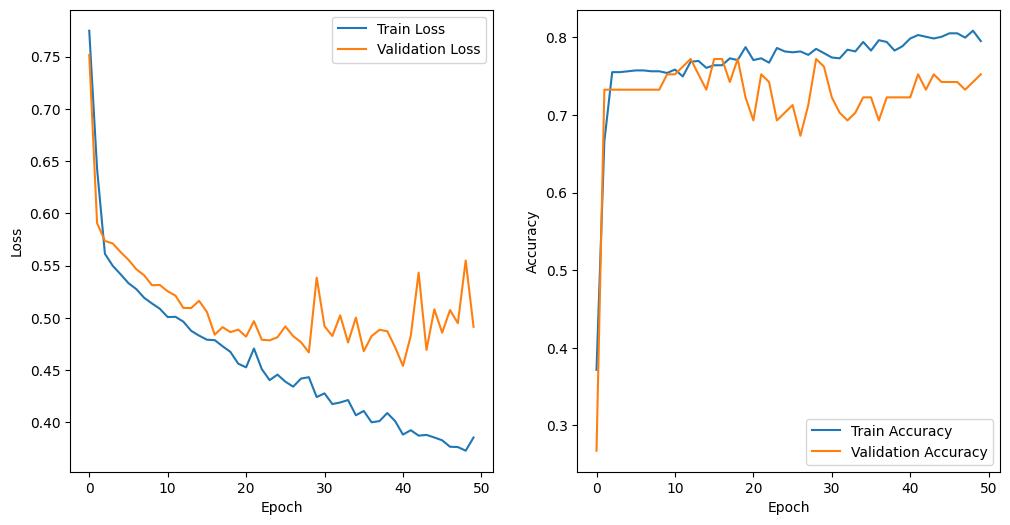

Modelo actualizado con el evento event000001000.


========================= Cargando datos para el evento: event000001001 =========================

Shape de X: (643, 9)	 Shape de y: (643,)

Positivos: 442	 Total negatives: 201
Dataset original length: 643
Train subset length: 578
Val subset length: 65


/home/alvar/repositorioTFG/ML_trackfinding/commonMLfunctions.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/home/alvar/repositorioTFG/ML_trackfinding/commonMLfunctions.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


- Epoch 1/50 completed.
	Train Loss: 0.7504, Train Acc: 0.4412
	Validation Loss: 0.7855, Validation Acc: 0.3077
	Time elapsed: 00:00:00
- Epoch 2/50 completed.
	Train Loss: 0.6993, Train Acc: 0.4895
	Validation Loss: 0.6590, Validation Acc: 0.6923
	Time elapsed: 00:00:01
- Epoch 3/50 completed.
	Train Loss: 0.5978, Train Acc: 0.6895
	Validation Loss: 0.6714, Validation Acc: 0.6923
	Time elapsed: 00:00:02
- Epoch 4/50 completed.
	Train Loss: 0.5735, Train Acc: 0.7211
	Validation Loss: 0.6415, Validation Acc: 0.7077
	Time elapsed: 00:00:02
- Epoch 5/50 completed.
	Train Loss: 0.5521, Train Acc: 0.7140
	Validation Loss: 0.6259, Validation Acc: 0.6769
	Time elapsed: 00:00:03
- Epoch 6/50 completed.
	Train Loss: 0.5372, Train Acc: 0.7246
	Validation Loss: 0.6190, Validation Acc: 0.7231
	Time elapsed: 00:00:04
- Epoch 7/50 completed.
	Train Loss: 0.5255, Train Acc: 0.7474
	Validation Loss: 0.6137, Validation Acc: 0.6615
	Time elapsed: 00:00:04
- Epoch 8/50 completed.
	Train Loss: 0.5213, Tra

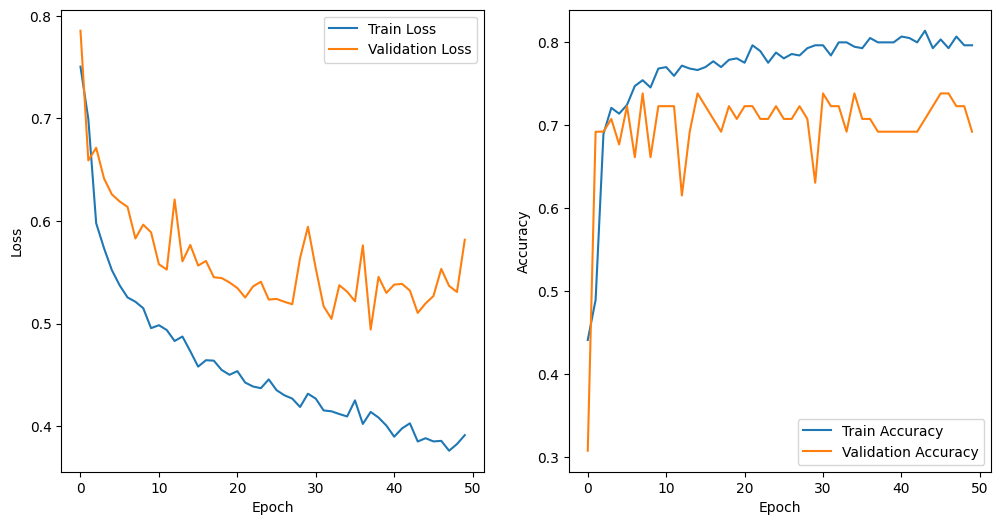

Modelo actualizado con el evento event000001001.


========================= Cargando datos para el evento: event000001002 =========================

Shape de X: (575, 9)	 Shape de y: (575,)

Positivos: 456	 Total negatives: 119
Dataset original length: 575
Train subset length: 517
Val subset length: 58


/home/alvar/repositorioTFG/ML_trackfinding/commonMLfunctions.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/home/alvar/repositorioTFG/ML_trackfinding/commonMLfunctions.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


- Epoch 1/50 completed.
	Train Loss: 0.7786, Train Acc: 0.3946
	Validation Loss: 0.9688, Validation Acc: 0.0862
	Time elapsed: 00:00:00
- Epoch 2/50 completed.
	Train Loss: 0.7444, Train Acc: 0.4047
	Validation Loss: 0.6434, Validation Acc: 0.9138
	Time elapsed: 00:00:01
- Epoch 3/50 completed.
	Train Loss: 0.6320, Train Acc: 0.7760
	Validation Loss: 0.5518, Validation Acc: 0.9138
	Time elapsed: 00:00:01
- Epoch 4/50 completed.
	Train Loss: 0.5769, Train Acc: 0.7800
	Validation Loss: 0.4665, Validation Acc: 0.9138
	Time elapsed: 00:00:02
- Epoch 5/50 completed.
	Train Loss: 0.5243, Train Acc: 0.7780
	Validation Loss: 0.3648, Validation Acc: 0.9138
	Time elapsed: 00:00:02
- Epoch 6/50 completed.
	Train Loss: 0.4789, Train Acc: 0.7878
	Validation Loss: 0.3001, Validation Acc: 0.9655
	Time elapsed: 00:00:03
- Epoch 7/50 completed.
	Train Loss: 0.4545, Train Acc: 0.8350
	Validation Loss: 0.2679, Validation Acc: 0.9655
	Time elapsed: 00:00:03
- Epoch 8/50 completed.
	Train Loss: 0.4427, Tra

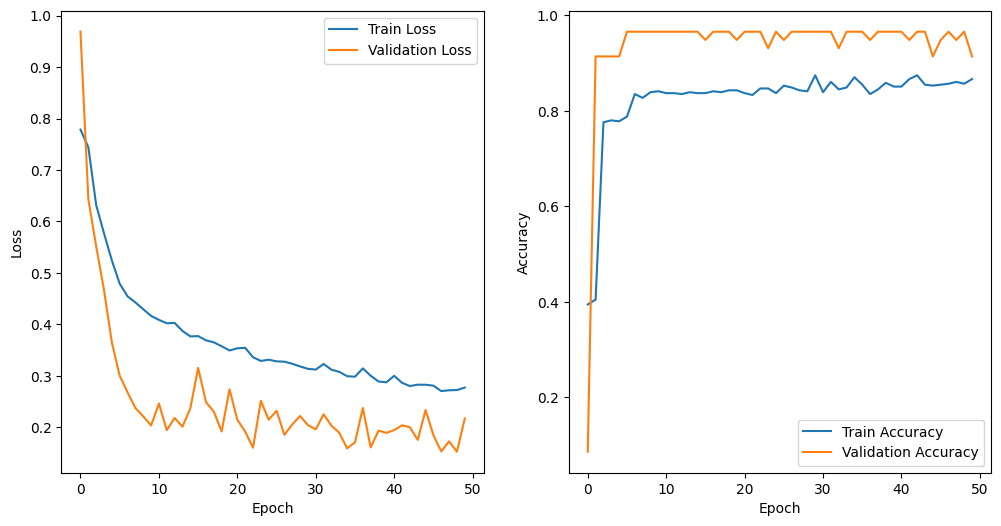

Modelo actualizado con el evento event000001002.


========================= Cargando datos para el evento: event000001003 =========================

Shape de X: (484, 9)	 Shape de y: (484,)

Positivos: 423	 Total negatives: 61
Dataset original length: 484
Train subset length: 435
Val subset length: 49


/home/alvar/repositorioTFG/ML_trackfinding/commonMLfunctions.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/home/alvar/repositorioTFG/ML_trackfinding/commonMLfunctions.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


- Epoch 1/50 completed.
	Train Loss: 0.7903, Train Acc: 0.4046
	Validation Loss: 0.9769, Validation Acc: 0.1633
	Time elapsed: 00:00:00
- Epoch 2/50 completed.
	Train Loss: 0.8189, Train Acc: 0.1265
	Validation Loss: 0.7094, Validation Acc: 0.1837
	Time elapsed: 00:00:00
- Epoch 3/50 completed.
	Train Loss: 0.6392, Train Acc: 0.7916
	Validation Loss: 0.5848, Validation Acc: 0.8367
	Time elapsed: 00:00:01
- Epoch 4/50 completed.
	Train Loss: 0.5107, Train Acc: 0.8782
	Validation Loss: 0.4903, Validation Acc: 0.8367
	Time elapsed: 00:00:01
- Epoch 5/50 completed.
	Train Loss: 0.4075, Train Acc: 0.8759
	Validation Loss: 0.4378, Validation Acc: 0.8367
	Time elapsed: 00:00:02
- Epoch 6/50 completed.
	Train Loss: 0.3678, Train Acc: 0.8759
	Validation Loss: 0.4147, Validation Acc: 0.8367
	Time elapsed: 00:00:02
- Epoch 7/50 completed.
	Train Loss: 0.3427, Train Acc: 0.8782
	Validation Loss: 0.3960, Validation Acc: 0.8367
	Time elapsed: 00:00:03
- Epoch 8/50 completed.
	Train Loss: 0.3327, Tra

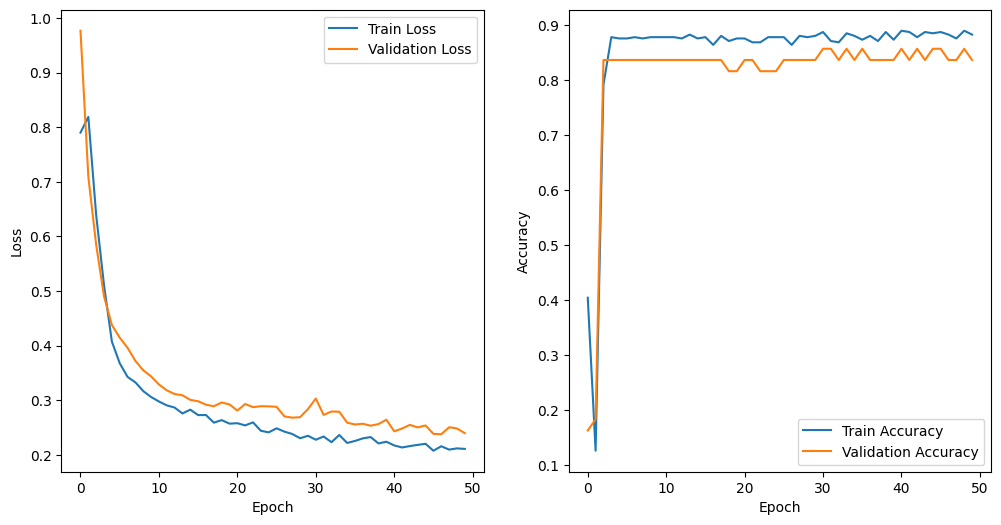

Modelo actualizado con el evento event000001003.


========================= Cargando datos para el evento: event000001004 =========================

Shape de X: (1405, 9)	 Shape de y: (1405,)

Positivos: 877	 Total negatives: 528
Dataset original length: 1405
Train subset length: 1264
Val subset length: 141


/home/alvar/repositorioTFG/ML_trackfinding/commonMLfunctions.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/home/alvar/repositorioTFG/ML_trackfinding/commonMLfunctions.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


- Epoch 1/50 completed.
	Train Loss: 0.7659, Train Acc: 0.4676
	Validation Loss: 0.7715, Validation Acc: 0.4043
	Time elapsed: 00:00:01
- Epoch 2/50 completed.
	Train Loss: 0.7027, Train Acc: 0.5127
	Validation Loss: 0.6638, Validation Acc: 0.5745
	Time elapsed: 00:00:02
- Epoch 3/50 completed.
	Train Loss: 0.6427, Train Acc: 0.6146
	Validation Loss: 0.6390, Validation Acc: 0.6028
	Time elapsed: 00:00:04
- Epoch 4/50 completed.
	Train Loss: 0.6082, Train Acc: 0.6696
	Validation Loss: 0.6118, Validation Acc: 0.7092
	Time elapsed: 00:00:05
- Epoch 5/50 completed.
	Train Loss: 0.5823, Train Acc: 0.6998
	Validation Loss: 0.5937, Validation Acc: 0.6950
	Time elapsed: 00:00:07
- Epoch 6/50 completed.
	Train Loss: 0.5703, Train Acc: 0.7046
	Validation Loss: 0.5883, Validation Acc: 0.7021
	Time elapsed: 00:00:08
- Epoch 7/50 completed.
	Train Loss: 0.5595, Train Acc: 0.7118
	Validation Loss: 0.5832, Validation Acc: 0.7092
	Time elapsed: 00:00:10
- Epoch 8/50 completed.
	Train Loss: 0.5578, Tra

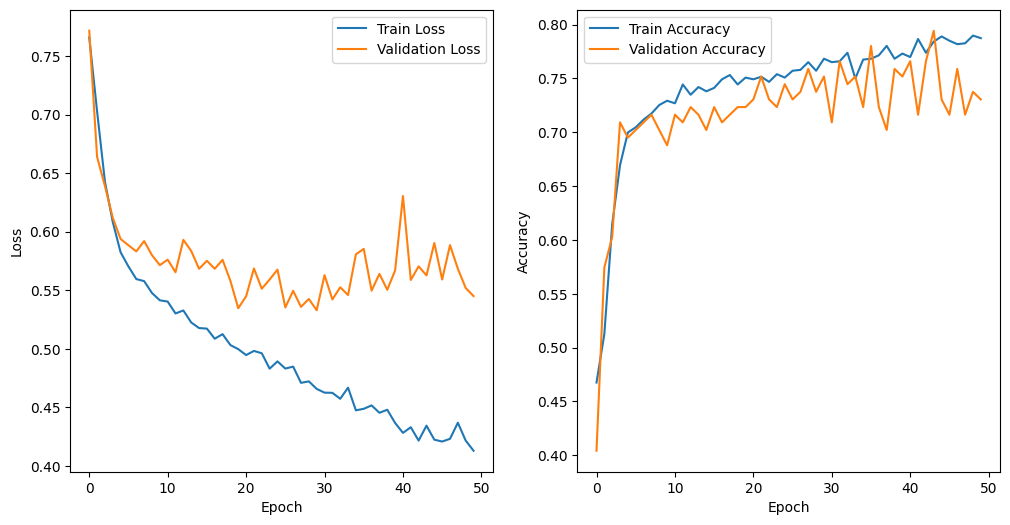

Modelo actualizado con el evento event000001004.


========================= Cargando datos para el evento: event000001005 =========================

Shape de X: (674, 9)	 Shape de y: (674,)

Positivos: 505	 Total negatives: 169
Dataset original length: 674
Train subset length: 606
Val subset length: 68


/home/alvar/repositorioTFG/ML_trackfinding/commonMLfunctions.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/home/alvar/repositorioTFG/ML_trackfinding/commonMLfunctions.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


- Epoch 1/50 completed.
	Train Loss: 0.8066, Train Acc: 0.4208
	Validation Loss: 0.8524, Validation Acc: 0.3235
	Time elapsed: 00:00:00
- Epoch 2/50 completed.
	Train Loss: 0.7893, Train Acc: 0.2592
	Validation Loss: 0.7035, Validation Acc: 0.3382
	Time elapsed: 00:00:01
- Epoch 3/50 completed.
	Train Loss: 0.6780, Train Acc: 0.5251
	Validation Loss: 0.6296, Validation Acc: 0.6912
	Time elapsed: 00:00:02
- Epoch 4/50 completed.
	Train Loss: 0.5320, Train Acc: 0.7625
	Validation Loss: 0.5997, Validation Acc: 0.7059
	Time elapsed: 00:00:02
- Epoch 5/50 completed.
	Train Loss: 0.4782, Train Acc: 0.7609
	Validation Loss: 0.6242, Validation Acc: 0.6912
	Time elapsed: 00:00:03
- Epoch 6/50 completed.
	Train Loss: 0.4535, Train Acc: 0.7642
	Validation Loss: 0.5725, Validation Acc: 0.6912
	Time elapsed: 00:00:04
- Epoch 7/50 completed.
	Train Loss: 0.4346, Train Acc: 0.7726
	Validation Loss: 0.5883, Validation Acc: 0.7059
	Time elapsed: 00:00:05
- Epoch 8/50 completed.
	Train Loss: 0.4267, Tra

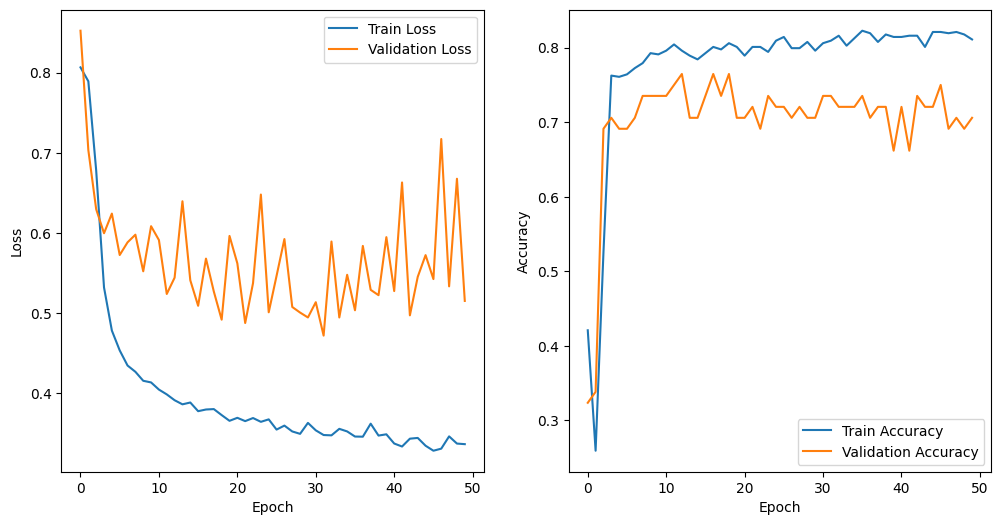

Modelo actualizado con el evento event000001005.


========================= Cargando datos para el evento: event000001006 =========================

Shape de X: (481, 9)	 Shape de y: (481,)

Positivos: 390	 Total negatives: 91
Dataset original length: 481
Train subset length: 432
Val subset length: 49


/home/alvar/repositorioTFG/ML_trackfinding/commonMLfunctions.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/home/alvar/repositorioTFG/ML_trackfinding/commonMLfunctions.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


- Epoch 1/50 completed.
	Train Loss: 0.8739, Train Acc: 0.3611
	Validation Loss: 0.8664, Validation Acc: 0.2041
	Time elapsed: 00:00:00
- Epoch 2/50 completed.
	Train Loss: 0.7839, Train Acc: 0.2193
	Validation Loss: 0.7148, Validation Acc: 0.3673
	Time elapsed: 00:00:01
- Epoch 3/50 completed.
	Train Loss: 0.6196, Train Acc: 0.5896
	Validation Loss: 0.5616, Validation Acc: 0.7755
	Time elapsed: 00:00:01
- Epoch 4/50 completed.
	Train Loss: 0.4904, Train Acc: 0.7877
	Validation Loss: 0.4933, Validation Acc: 0.7959
	Time elapsed: 00:00:02
- Epoch 5/50 completed.
	Train Loss: 0.4495, Train Acc: 0.8066
	Validation Loss: 0.4706, Validation Acc: 0.7959
	Time elapsed: 00:00:02
- Epoch 6/50 completed.
	Train Loss: 0.4120, Train Acc: 0.8113
	Validation Loss: 0.4615, Validation Acc: 0.7959
	Time elapsed: 00:00:03
- Epoch 7/50 completed.
	Train Loss: 0.3931, Train Acc: 0.8184
	Validation Loss: 0.4539, Validation Acc: 0.7959
	Time elapsed: 00:00:03
- Epoch 8/50 completed.
	Train Loss: 0.3704, Tra

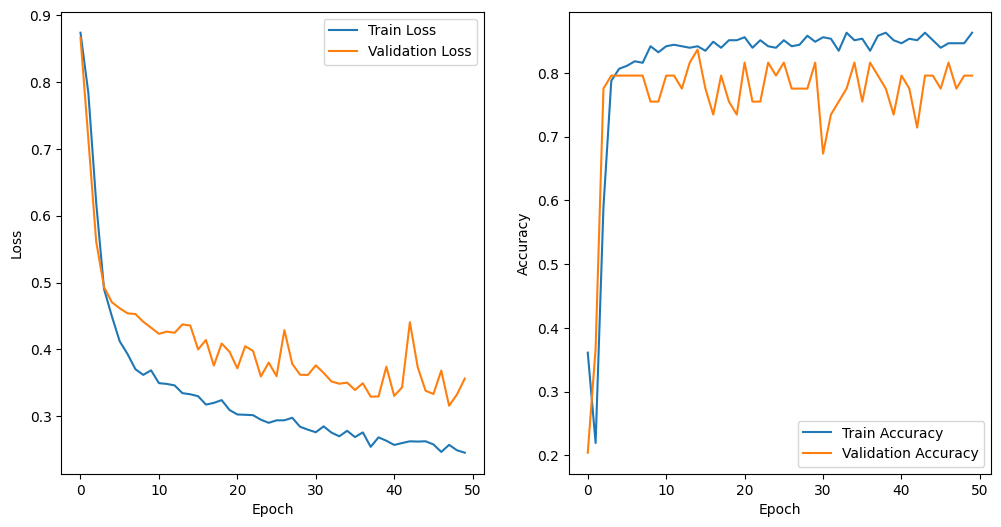

Modelo actualizado con el evento event000001006.


========================= Cargando datos para el evento: event000001007 =========================

Shape de X: (786, 9)	 Shape de y: (786,)

Positivos: 620	 Total negatives: 166
Dataset original length: 786
Train subset length: 707
Val subset length: 79


/home/alvar/repositorioTFG/ML_trackfinding/commonMLfunctions.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/home/alvar/repositorioTFG/ML_trackfinding/commonMLfunctions.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


- Epoch 1/50 completed.
	Train Loss: 0.8500, Train Acc: 0.3904
	Validation Loss: 0.8395, Validation Acc: 0.1392
	Time elapsed: 00:00:00
- Epoch 2/50 completed.
	Train Loss: 0.7431, Train Acc: 0.2804
	Validation Loss: 0.7031, Validation Acc: 0.4937
	Time elapsed: 00:00:01
- Epoch 3/50 completed.
	Train Loss: 0.6404, Train Acc: 0.7039
	Validation Loss: 0.5067, Validation Acc: 0.7975
	Time elapsed: 00:00:02
- Epoch 4/50 completed.
	Train Loss: 0.5293, Train Acc: 0.7740
	Validation Loss: 0.4328, Validation Acc: 0.8481
	Time elapsed: 00:00:03
- Epoch 5/50 completed.
	Train Loss: 0.5099, Train Acc: 0.7783
	Validation Loss: 0.4166, Validation Acc: 0.8608
	Time elapsed: 00:00:04
- Epoch 6/50 completed.
	Train Loss: 0.4868, Train Acc: 0.7811
	Validation Loss: 0.3887, Validation Acc: 0.8608
	Time elapsed: 00:00:04
- Epoch 7/50 completed.
	Train Loss: 0.4742, Train Acc: 0.7797
	Validation Loss: 0.3825, Validation Acc: 0.8608
	Time elapsed: 00:00:05
- Epoch 8/50 completed.
	Train Loss: 0.4573, Tra

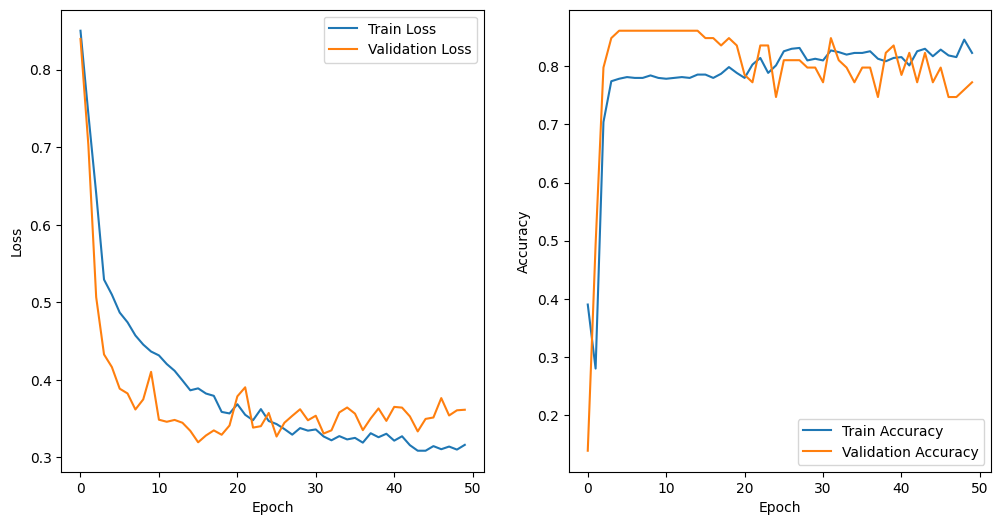

Modelo actualizado con el evento event000001007.


========================= Cargando datos para el evento: event000001008 =========================

Shape de X: (509, 9)	 Shape de y: (509,)

Positivos: 406	 Total negatives: 103
Dataset original length: 509
Train subset length: 458
Val subset length: 51


/home/alvar/repositorioTFG/ML_trackfinding/commonMLfunctions.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/home/alvar/repositorioTFG/ML_trackfinding/commonMLfunctions.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


- Epoch 1/50 completed.
	Train Loss: 0.8895, Train Acc: 0.3755
	Validation Loss: 0.8966, Validation Acc: 0.1765
	Time elapsed: 00:00:00
- Epoch 2/50 completed.
	Train Loss: 0.7507, Train Acc: 0.3756
	Validation Loss: 0.6314, Validation Acc: 0.7647
	Time elapsed: 00:00:01
- Epoch 3/50 completed.
	Train Loss: 0.5659, Train Acc: 0.7600
	Validation Loss: 0.4159, Validation Acc: 0.8627
	Time elapsed: 00:00:01
- Epoch 4/50 completed.
	Train Loss: 0.4960, Train Acc: 0.7911
	Validation Loss: 0.3958, Validation Acc: 0.8627
	Time elapsed: 00:00:02
- Epoch 5/50 completed.
	Train Loss: 0.4842, Train Acc: 0.7889
	Validation Loss: 0.4056, Validation Acc: 0.8627
	Time elapsed: 00:00:02
- Epoch 6/50 completed.
	Train Loss: 0.4728, Train Acc: 0.7911
	Validation Loss: 0.3778, Validation Acc: 0.8627
	Time elapsed: 00:00:03
- Epoch 7/50 completed.
	Train Loss: 0.4586, Train Acc: 0.7978
	Validation Loss: 0.3822, Validation Acc: 0.8627
	Time elapsed: 00:00:03
- Epoch 8/50 completed.
	Train Loss: 0.4612, Tra

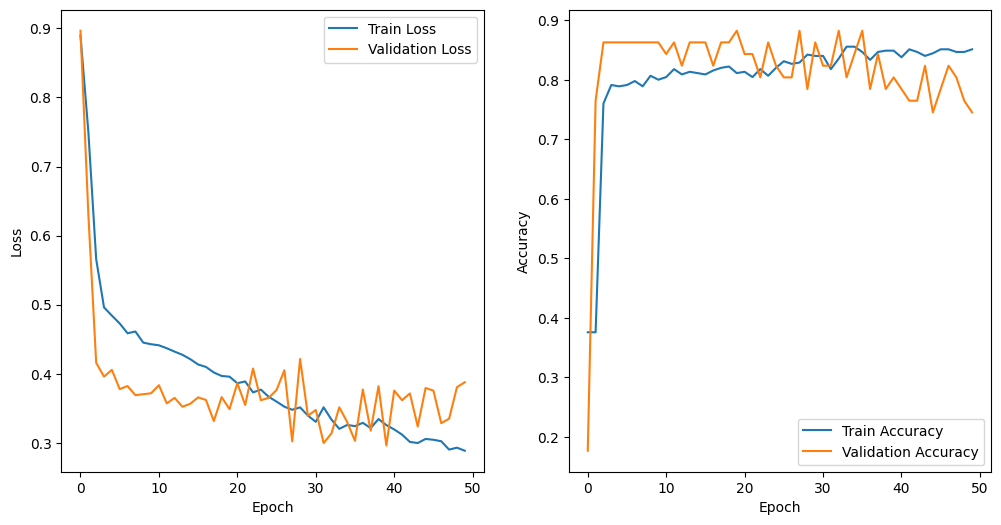

Modelo actualizado con el evento event000001008.


========================= Cargando datos para el evento: event000001009 =========================

Shape de X: (537, 9)	 Shape de y: (537,)

Positivos: 414	 Total negatives: 123
Dataset original length: 537
Train subset length: 483
Val subset length: 54


/home/alvar/repositorioTFG/ML_trackfinding/commonMLfunctions.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/home/alvar/repositorioTFG/ML_trackfinding/commonMLfunctions.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


- Epoch 1/50 completed.
	Train Loss: 0.8754, Train Acc: 0.4203
	Validation Loss: 0.8288, Validation Acc: 0.2778
	Time elapsed: 00:00:00
- Epoch 2/50 completed.
	Train Loss: 0.7524, Train Acc: 0.3516
	Validation Loss: 0.7142, Validation Acc: 0.4259
	Time elapsed: 00:00:01
- Epoch 3/50 completed.
	Train Loss: 0.6390, Train Acc: 0.6526
	Validation Loss: 0.6036, Validation Acc: 0.7407
	Time elapsed: 00:00:01
- Epoch 4/50 completed.
	Train Loss: 0.5614, Train Acc: 0.7684
	Validation Loss: 0.5230, Validation Acc: 0.7593
	Time elapsed: 00:00:02
- Epoch 5/50 completed.
	Train Loss: 0.5176, Train Acc: 0.7705
	Validation Loss: 0.4732, Validation Acc: 0.7593
	Time elapsed: 00:00:03
- Epoch 6/50 completed.
	Train Loss: 0.4984, Train Acc: 0.7705
	Validation Loss: 0.4527, Validation Acc: 0.7593
	Time elapsed: 00:00:03
- Epoch 7/50 completed.
	Train Loss: 0.4811, Train Acc: 0.7726
	Validation Loss: 0.4406, Validation Acc: 0.7593
	Time elapsed: 00:00:04
- Epoch 8/50 completed.
	Train Loss: 0.4670, Tra

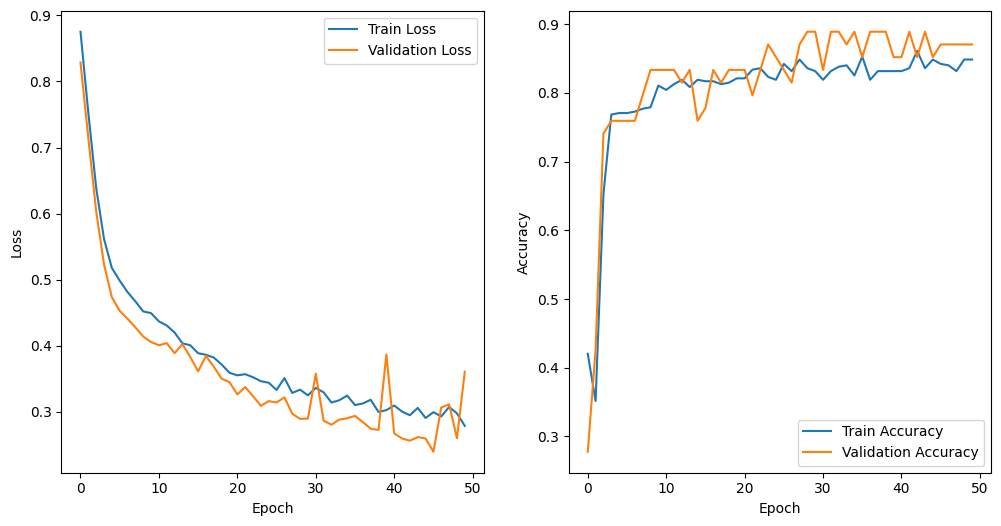

Modelo actualizado con el evento event000001009.



In [ ]:
from model import TripletNet, SimpleNet
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from commonMLfunctions import TripletDataset, create_dataloaders
from common import *
from commonMLfunctions import write_metrics_to_log, training_triplet_model, predict_all
%matplotlib inline

model = None  # Inicializa el modelo vacío
best_f1 = 0

for event in events:
    print(f"\n========================= Cargando datos para el evento: {event} =========================\n")

    # Verificamos si el archivo existe
    if not os.path.exists(output_path):
        print(f"El archivo triplets_data_{event}.npz no existe. Por favor, genera los triplets primero.")
        continue

    # Entrenamos y actualizamos el modelo con el evento actual
    model = training_triplet_model(event, model=model)
    print(f"Modelo actualizado con el evento {event}.\n")

    # y_true, y_pred = predict_all(model, val_loader)
    # f1 = f1_score(y_true, y_pred)
    # if f1 > best_f1:
    #     best_f1 = f1
    #     torch.save(model.state_dict(), f'best_model.pth')
    # #torch.save(model.state_dict(), f'model_after_{event}.pth')


# Guardamos el modelo final con fecha y hora
from datetime import datetime
current_time = datetime.now().strftime("%m%d_%H:%M:%S")
model_save_name = f'triplet_model_{current_time}.pth'

model_save_path = os.path.join(data_dir, model_save_name)

torch.save(model.state_dict(), model_save_path)


## Evaluación del modelo final

In [ ]:
import torch
from model import TripletNet
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from commonMLfunctions import create_dataloaders
import numpy as np

# === Cargar el modelo ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TripletNet().to(device)
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.eval()

# === Cargar datos de validación ===
event = events[0]  
data = np.load(f"triplets_data_{event}.npz")
X = torch.tensor(data["X"], dtype=torch.float32)
y = torch.tensor(data["y"], dtype=torch.float32)

_, val_loader = create_dataloaders(X, y, batch_size=16)  

# === Evaluación ===
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch = x_batch.to(device)
        logits = model(x_batch)
        preds = (torch.sigmoid(logits) > 0.5).float().cpu()
        y_true_all.append(y_batch.cpu())
        y_pred_all.append(preds)

y_true = torch.cat(y_true_all).numpy()
y_pred = torch.cat(y_pred_all).numpy()

# === Métricas ===
print("\n=== Evaluación del modelo final ===")
print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
print(f"F1-score:  {f1_score(y_true, y_pred):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))


Dataset original length: 1008
Train subset length: 907
Val subset length: 101

=== Evaluación del modelo final ===
Accuracy:  0.7327
Precision: 0.7374
Recall:    0.9865
F1-score:  0.8439

Confusion Matrix:
[[ 1 26]
 [ 1 73]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.5000    0.0370    0.0690        27
         1.0     0.7374    0.9865    0.8439        74

    accuracy                         0.7327       101
   macro avg     0.6187    0.5118    0.4564       101
weighted avg     0.6739    0.7327    0.6368       101



/home/alvar/repositorioTFG/ML_trackfinding/commonMLfunctions.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/home/alvar/repositorioTFG/ML_trackfinding/commonMLfunctions.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


X_triplets_scaled stats antes de desescalar:
Min: tensor(-1.4993) Max: tensor(1.4984) Mean: tensor(-0.1341)
X_triplets_flat shape: (101, 9)
X_triplets_descaled_flat stats después de desescalar:
Min: -1.499329 Max: 1.4983981 Mean: -0.13408601
Original: TP=73, TN=1, FP=26, FN=1
Mostrando: TP=73, TN=1, FP=25, FN=1
Accuracy: 73.2673%
F1 Score: 0.8439


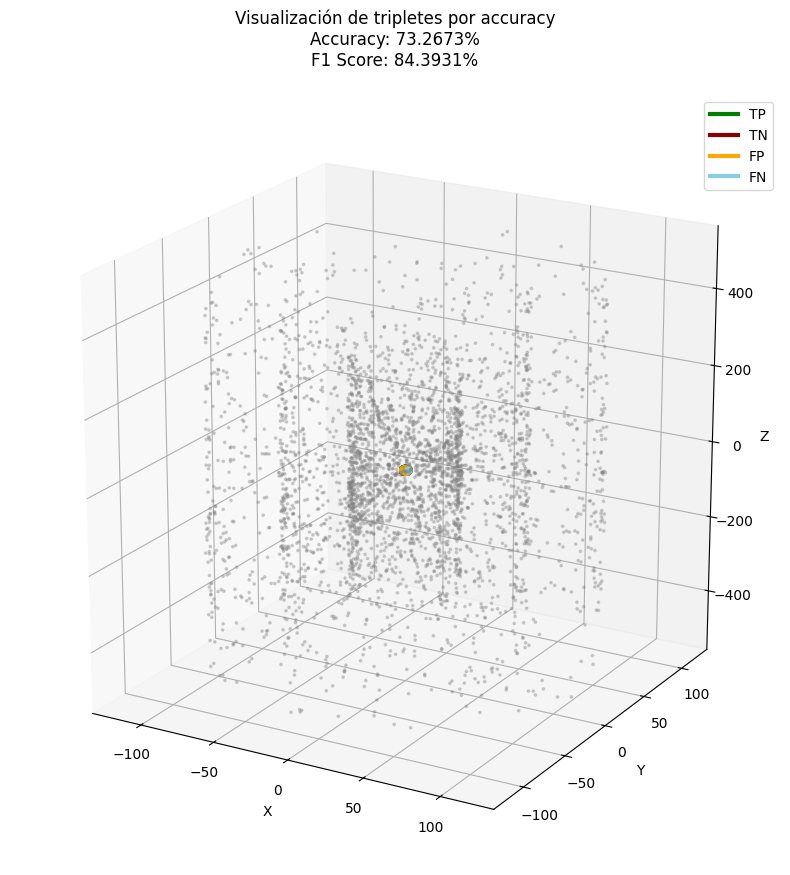

In [ ]:
import random
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np

scaler = np.load(output_path, allow_pickle=True)['scaler'].item()

def visualize_triplets_by_accuracy_sampled(X_triplets_scaled, y_true, y_pred, scaler,
                                          title='Visualización por accuracy', total_to_show=100):
    y_true = np.array(y_true).astype(int)
    y_pred = np.array(y_pred).astype(int)

    min_len = min(len(y_true), len(y_pred), len(X_triplets_scaled))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]
    X_triplets_scaled = X_triplets_scaled[:min_len]

    print("X_triplets_scaled stats antes de desescalar:")
    print("Min:", X_triplets_scaled.min(), "Max:", X_triplets_scaled.max(), "Mean:", X_triplets_scaled.mean())

    # Convertimos a numpy si es tensor
    X_triplets_flat = X_triplets_scaled.reshape(min_len, -1)
    if hasattr(X_triplets_flat, "cpu"):  # Detecta si es tensor PyTorch
        X_triplets_flat = X_triplets_flat.cpu().numpy()
    else:
        X_triplets_flat = np.array(X_triplets_flat)

    print("X_triplets_flat shape:", X_triplets_flat.shape)

    X_triplets_descaled_flat = scaler.inverse_transform(X_triplets_flat)

    print("X_triplets_descaled_flat stats después de desescalar:")
    print("Min:", X_triplets_descaled_flat.min(), "Max:", X_triplets_descaled_flat.max(), "Mean:", X_triplets_descaled_flat.mean())

    X_triplets_descaled = X_triplets_descaled_flat.reshape(min_len, 3, 3)

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(layer1.x, layer1.y, layer1.z, c='gray', alpha=0.3, s=3, label='Layer 1')
    ax.scatter(layer2.x, layer2.y, layer2.z, c='gray', alpha=0.3, s=3, label='Layer 2')
    ax.scatter(layer3.x, layer3.y, layer3.z, c='gray', alpha=0.3, s=3, label='Layer 3')

    ax.set_box_aspect([1, 1, 1])
    ax.view_init(elev=20, azim=-60)

    tp_idx = np.where((y_true == 1) & (y_pred == 1))[0]
    tn_idx = np.where((y_true == 0) & (y_pred == 0))[0]
    fp_idx = np.where((y_true == 0) & (y_pred == 1))[0]
    fn_idx = np.where((y_true == 1) & (y_pred == 0))[0]

    counts = {'TP': len(tp_idx), 'TN': len(tn_idx), 'FP': len(fp_idx), 'FN': len(fn_idx)}
    total = sum(counts.values())
    proportions = {k: v / total for k, v in counts.items()}

    sampled_counts = {k: max(1, int(proportions[k] * total_to_show)) for k in proportions}
    difference = total_to_show - sum(sampled_counts.values())
    if difference != 0:
        sorted_keys = sorted(counts.items(), key=lambda x: -x[1])
        for k, _ in sorted_keys:
            sampled_counts[k] += difference
            break

    sampled = {
        'TP': random.sample(list(tp_idx), min(sampled_counts['TP'], len(tp_idx))),
        'TN': random.sample(list(tn_idx), min(sampled_counts['TN'], len(tn_idx))),
        'FP': random.sample(list(fp_idx), min(sampled_counts['FP'], len(fp_idx))),
        'FN': random.sample(list(fn_idx), min(sampled_counts['FN'], len(fn_idx))),
    }

    def plot_triplets(indices, color, alpha):
        for i in indices:
            triplet = X_triplets_descaled[i]
            ax.plot(triplet[:, 0], triplet[:, 1], triplet[:, 2], c=color, alpha=alpha, marker='o', markersize=5)

    plot_triplets(sampled['TP'], 'green', 0.9)
    plot_triplets(sampled['TN'], 'darkred', 0.9)
    plot_triplets(sampled['FP'], 'orange', 0.5)
    plot_triplets(sampled['FN'], 'skyblue', 0.5)

    acc = (counts['TP'] + counts['TN']) / total if total else 0.0

    print(f"Original: TP={counts['TP']}, TN={counts['TN']}, FP={counts['FP']}, FN={counts['FN']}")
    print(f"Mostrando: TP={len(sampled['TP'])}, TN={len(sampled['TN'])}, FP={len(sampled['FP'])}, FN={len(sampled['FN'])}")
    print(f"Accuracy: {acc:.4%}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")

    ax.set_title(f"{title}\nAccuracy: {acc:.4%}\nF1 Score: {f1_score(y_true, y_pred)*100:.4f}%\n")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    handles = [
        plt.Line2D([0], [0], color='green', lw=3),
        plt.Line2D([0], [0], color='darkred', lw=3),
        plt.Line2D([0], [0], color='orange', lw=3),
        plt.Line2D([0], [0], color='skyblue', lw=3)
    ]
    labels = ['TP', 'TN', 'FP', 'FN']
    ax.legend(handles, labels)

    plt.show()

# Visualizar tripletes por accuracy
visualize_triplets_by_accuracy_sampled(X, y_true, y_pred, scaler, 
                                        title='Visualización de tripletes por accuracy', 
                                        total_to_show=100)